In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
taxonomy = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/taxonomy_engagement_data.csv')
taxonomy.columns

Index(['id', 'user_id', 'content_id', 'engagement_metadata', 'media_type',
       's3_url', 'is_like', 'is_dislike', 'msEngagement', 'seed',
       'num_inference_steps', 'guidance_scale', 'prompt', 'original_prompt',
       'artist_style', 'source', 'generated_type', 'model', 'model_version',
       'text'],
      dtype='object')

In [ ]:
content = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/content.csv') # 180,508 non-duplicated rows
content.columns

Index(['content_id', 'media_type', 's3_url', 'seed', 'num_inference_steps',
       'guidance_scale', 'prompt', 'original_prompt', 'artist_style', 'source',
       'generated_type', 'model', 'model_version', 'text'],
      dtype='object')

In [ ]:
def calculate_interaction(df):
    """
    Args:
        df: DataFrame containing content_id, msEngagement, is_like, and is_dislike columns
    """
    df.fillna({'msEngagement': 0}, inplace=True)
    data_clean = df.groupby(['user_id','content_id']).agg({'media_type': 'first', 'prompt': 'first', 's3_url': 'first',
                                                 'msEngagement': 'mean', 'is_like': 'mean', 'is_dislike': 'mean'}).reset_index()
    scaler = MinMaxScaler()
    data_clean['msEngagement'] = scaler.fit_transform(data_clean[['msEngagement']])
    data_clean['interaction'] = (data_clean['is_like'] - data_clean['is_dislike']) * 1.5 + data_clean['msEngagement'] # weigh likes a little bit more than engagement
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_clean['interaction'] = scaler.fit_transform(data_clean[['interaction']])

    return data_clean

In [ ]:
taxonomy = calculate_interaction(taxonomy)

## BERT embeddings

In [ ]:
def preprocess_text(text, stopwords, stem, lemma):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    token = text.split()
    token = [word for word in token if word not in stopwords]
    if stem == True:
        ps = nltk.stem.porter.PorterStemmer()
        token = [ps.stem(word) for word in token]
    if lemma == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        token = [lem.lemmatize(word) for word in token]
    text = " ".join(token)
    return text

In [ ]:
def generate_embeddings(df):
    """
    Returns a list of BERT embeddings for each prompt in the DataFrame
    """
    stop_words = stopwords.words("english")

    df.loc[:, 'prompt_clean'] = df['prompt'].apply(lambda x: preprocess_text(x, stop_words, True, True))
    df_prompts = df['prompt_clean'].dropna().tolist()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased').to(device)
    svd = TruncatedSVD(n_components=128)
    scaler = StandardScaler()

    def get_embeddings(text):
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
        outputs = model(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().detach().numpy()
        return embeddings

    embeddings = [get_embeddings(prompt) for prompt in df_prompts]
    embeddings = np.array([embedding[0] for embedding in embeddings])
    embeddings_df = pd.DataFrame(embeddings).reset_index(drop=True)
    media_type_dummies = pd.get_dummies(df['media_type'], prefix='media_type')
    media_type_dummies = media_type_dummies.astype(int).reset_index(drop=True)
    prompt_media_embeddings = pd.concat([embeddings_df, media_type_dummies], axis=1)
    prompt_media_embeddings.columns = prompt_media_embeddings.columns.astype(str)
    standardized_features = scaler.fit_transform(prompt_media_embeddings)
    reduced_embeddings = svd.fit_transform(standardized_features)

    return reduced_embeddings

In [ ]:
# prompt_media_embeddings = generate_embeddings(content)
# np.save('/content/drive/MyDrive/Colab Notebooks/full_content_embeddings.npy', np.array(prompt_media_embeddings))

In [ ]:
prompt_media_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/full_content_embeddings.npy')
print(prompt_media_embeddings.shape)
content['embeddings'] = prompt_media_embeddings.tolist()

(180508, 128)


# Clustering

In [ ]:
# n_components=128
# pca = PCA(n_components=n_components)
# pca_features = pca.fit_transform(prompt_media_embeddings)
# pca_df = pd.DataFrame(pca_features, columns=[f'PCA_{i}' for i in range(n_components)])

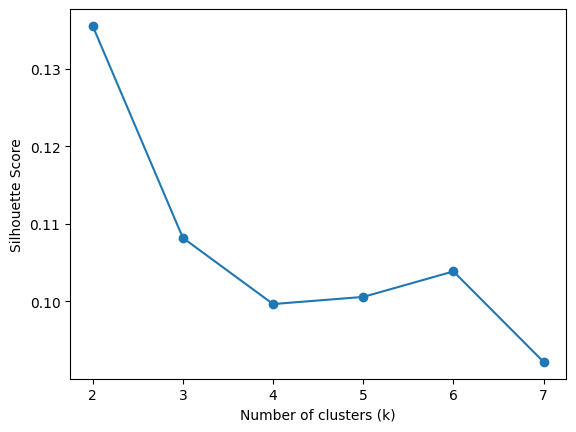

In [ ]:
silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 'auto')
    labels = kmeans.fit_predict(prompt_media_embeddings)
    silhouette_avg = silhouette_score(prompt_media_embeddings, labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2,8), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(prompt_media_embeddings)
content['cluster'] = kmeans.labels_
content['cluster'].value_counts()

,count
cluster,
1,58155
5,32500
0,28851
3,22991
4,21452
2,16559


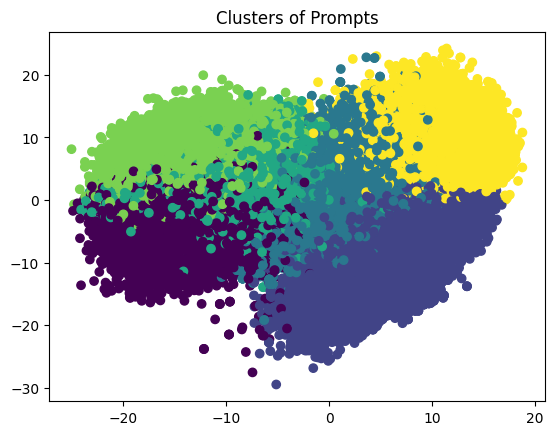

In [ ]:
plt.scatter(prompt_media_embeddings[:, 0], prompt_media_embeddings[:, 1], c=kmeans.labels_)
plt.title("Clusters of Prompts")
plt.show()

In [ ]:
from IPython.display import display, Image, clear_output

test = content[content['cluster'] == 4]
def display_content(content_id):
    """Displays a single content piece."""
    pd.set_option('display.max_colwidth', None)
    content_displayed = content[content['content_id'] == content_id].iloc[0,:-2]

    display(pd.DataFrame(content_displayed).T)
    if content_displayed['media_type']=='Image':
        display(Image(url=content_displayed['s3_url'], width=300, height=300))
# for i in range(10):
#     display_content(test.iloc[i,0])

# Online Candidate Generator

In [ ]:
def get_content(user_data, user_id, number_of_content, full_content, offset=0):
    user_data = user_data[user_data['user_id'] == user_id]
    if user_data.empty:
        return

    # user_data = calculate_interaction(user_data) # use this if used real-time online, in order to calculate interaction
    # get contents that are liked by the user
    high_interaction_content = user_data[user_data['interaction'] > 0.49]

    if not high_interaction_content.empty:
        # if user engages with data that is not included in content.csv
        # user_embeddings = generate_embeddings(high_interaction_content)
        # embeddings of all positive interacted content
        user_embeddings = full_content[full_content['content_id'].isin(high_interaction_content['content_id'].explode().unique())]['embeddings'].tolist()
        highest_interaction_content = high_interaction_content.sort_values(by='interaction', ascending=False).loc[0, 'content_id']
        cluster_label = full_content.loc[full_content['content_id'] == highest_interaction_content, 'cluster'].values[0]
    else:
        return

    # find similar content in the same cluster with the one mostly liked by the user
    cluster_data = full_content[full_content['cluster']==cluster_label]
    # similarity between positive interacted content and all the cluster data
    similarity_scores = cosine_similarity(user_embeddings, cluster_data['embeddings'].tolist())
    similarity_scores = np.mean(similarity_scores, axis=0)
    sorted_indices = np.argsort(similarity_scores)[::-1]
    sorted_content_ids = [cluster_data.iloc[i]['content_id'] for i in sorted_indices]

    existing_content = user_data['content_id'].tolist()
    sorted_content_ids = [item for item in sorted_content_ids if item not in existing_content]

    return sorted_content_ids[offset:offset + number_of_content]

In [ ]:
rec = get_content(taxonomy, '00328ce57bbc14b33bd6695bc8eb32cdf2fb5f3a7d89ec14a42825e15d39df60', 20, content, 0)

In [ ]:
for i in rec:
    display_content(i)

# Multi-Armed Bandit with Popular Generator and Candidate Generator from previous assignment

In [ ]:
user_data = pd.DataFrame(columns=['user_id', 'content_id', 'interaction'])

In [ ]:
# generate a random piece of content from taxonomy (all engagement data) with highest interaction
def generate_popular_content(user_id):
    global user_data  # user_data is the specific user history data that keeps updating
    popular_content = taxonomy[taxonomy['interaction'] == taxonomy['interaction'].max()]['content_id'].tolist()
    if popular_content:
        rec = random.choice(popular_content)
        # update user_data as if it's online and assume interaction is 0.5
        user_data = pd.concat([user_data, pd.DataFrame([{'user_id': user_id, 'content_id': rec, 'interaction': 0.5}])], ignore_index=True)
        return rec
    else:
        return

def generate_custom_content(user_id):
    global user_data  # user_data is the specific user history data that keeps updating
    rec = get_content(user_data, user_id, 1, content, 0)
    # update user_data as if it's online and assume interaction is 0.5
    user_data = pd.concat([user_data, pd.DataFrame([{'user_id': user_id, 'content_id': rec[0], 'interaction': 0.5}])], ignore_index=True)
    return rec[0] if rec[0] else None

def calculate_reward(user_id, content_id):
    # if the recommended content_id&user_id is in taxonomy data
    if not taxonomy[(taxonomy['user_id']==user_id) & (taxonomy['content_id']==content_id)].empty:
        interaction = taxonomy[(taxonomy['user_id']==user_id) & (taxonomy['content_id']==content_id)]['interaction'].values.mean()
        return interaction
    else:
        cluster = content[content['content_id'] == content_id]['cluster'].values[0] # the cluster of the recommended content
        # get the user interaction history within the same cluster from taxonomy as synthetic data
        user_taxonomy_data = taxonomy[taxonomy['user_id'] == user_id]
        cluster_interactions = user_taxonomy_data[user_taxonomy_data['content_id'].isin(content[content['cluster'] == cluster]['content_id'])]['interaction']
        # return the average interaction score within the cluster
        return cluster_interactions.mean()

def run_epsilon_greedy(user_id, num_bandits, num_trials, epsilon=0.1):
    q_values = [0] * num_bandits
    n_values = [0] * num_bandits
    rewards = []
    average_rewards = []
    total_reward = 0
    arms = ['popular', 'custom']
    rec = []

    for trial in range(num_trials):
        if random.uniform(0, 1) < epsilon:
            # Explore
            chosen_bandit = random.randrange(num_bandits)
        else:
            # Exploit
            chosen_bandit = q_values.index(max(q_values))

        # generate content based on the chosen bandit
        if chosen_bandit == 0:
            content_id = generate_popular_content(user_id)
        else:
            content_id = generate_custom_content(user_id)

        if content_id:
            reward = calculate_reward(user_id, content_id)
        else:
            reward = 0

        rec.append(content_id)
        n_values[chosen_bandit] += 1
        q_values[chosen_bandit] += (1 / n_values[chosen_bandit]) * (reward - q_values[chosen_bandit])

        total_reward += reward
        rewards.append(reward)
        average_rewards.append(total_reward / (trial + 1))  # Store average reward

    average_reward_all_arms = sum(q_values) / num_bandits
    ev = (1 - epsilon) * max(q_values) + epsilon * average_reward_all_arms
    return rewards, average_rewards, ev, q_values, rec

user_id = '00328ce57bbc14b33bd6695bc8eb32cdf2fb5f3a7d89ec14a42825e15d39df60'
num_bandits = 2
num_trials = 50

rewards, average_rewards, ev, q_values, rec = run_epsilon_greedy(user_id, num_bandits, num_trials, epsilon=0.5)
print("Rewards:", rewards)
print("Average Rewards:", average_rewards)
print("Expected Value (EV):", ev)
print("Estimated Q-values:", q_values)

<ipython-input-19-68e40d3c3a1c>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  user_data = pd.concat([user_data, pd.DataFrame([{'user_id': user_id, 'content_id': rec, 'interaction': 0.5}])], ignore_index=True)


Rewards: [-0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.15112314887305012, -0.15112314887305012, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.06308294339386923, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.15112314887305012, -0.011642722250262598, -0.011642722250262598, -0.15112314887305012, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.011642722250262598, -0.06308294339386923, -0.011642722250262598, -0.011642722250262598, -0.0116

In [ ]:
# pos = taxonomy[taxonomy['user_id'] == user_id].sort_values(by='interaction', ascending=False)
# actual = pos[pos.interaction>0.49].content_id.values
# len(np.unique(actual))

447

In [ ]:
# same = 0
# for i in range(len(rec)):
#     if rec[i] in actual:
#         same += 1
# print(same)

1
